In [1]:
%run setup.ipynb

# fst

In [98]:
callset = phase2_ar1.callset_pass_biallelic
df_samples = phase2_ar1.df_samples
#df_samples.reset_index(inplace=True)
populations = phase2_ar1.pop_ids
pop_labels = phase2_ar1.pop_labels
pop_colours = phase2_ar1.pop_colors

#make idx dict for subpops
idx_dic = {p : list(df_samples[df_samples.population == p].index) for p in populations}
region_3R_free = '3R-free', '3R', 1, 37000000
region_3L_free = '3L-free', '3L', 15000000, 41000000

In [7]:
@functools.lru_cache(maxsize=None)
def load_ac(pop_id, chrom):
    genotypes = allel.GenotypeDaskArray(callset[chrom]['calldata/genotype'])
    ac = genotypes.take(idx_dic[pop_id], axis=1).count_alleles().compute()
    return ac


@functools.lru_cache(maxsize=None)
def compute_pair_fst(pops, regions, blen=10000):
    # order is irrelevant
    pop1, pop2 = pops
    
    with section('load allele counts'):
        ac1 = None
        ac2 = None
        for rname, chrom, start, stop in regions:
            pos = allel.SortedIndex(callset[chrom]['variants/POS'])
            loc = pos.locate_range(start, stop)
            rac1 = load_ac(pop1, chrom)[loc]
            rac2 = load_ac(pop2, chrom)[loc]
            if ac1 is None:
                ac1 = rac1
                ac2 = rac2
            else:
                ac1 = np.vstack([ac1, rac1])
                ac2 = np.vstack([ac2, rac2])
    
    ac1 = allel.AlleleCountsArray(ac1)
    ac2 = allel.AlleleCountsArray(ac2)
    with section('ascertain SNPs'):
        loc_asc = ac1.is_segregating() & ac2.is_segregating() & (ac1.max_allele() <= 1) & (ac2.max_allele() <= 1)
        ac1 = ac1[loc_asc]
        ac2 = ac2[loc_asc]
    
    # compute Fst
    fst, se, _, _ = allel.blockwise_hudson_fst(ac1, ac2, blen)
    
    return fst, se


def compute_pairwise_fst(regions, blen=10000):
    pairwise_fst = list()
    pairwise_fst_se = list()
    for pop1, pop2 in itertools.combinations(populations, 2):
        pops = tuple(sorted([pop1, pop2]))
        fst, se = compute_pair_fst(pops=pops, regions=regions, blen=blen)
        pairwise_fst.append(fst)
        pairwise_fst_se.append(se)
    return pairwise_fst, pairwise_fst_se


def tabulate_pairwise_fst(regions, blen=10000):
    fst, se = compute_pairwise_fst(regions, blen=blen)
    fstsq = scipy.spatial.distance.squareform(fst)
    sesq = scipy.spatial.distance.squareform(se)
    data = [zip(r1, r2) for r1, r2 in zip(fstsq, sesq)]
    tbl_fst = (etl
        .wrap(data)
        .pushheader(populations)
        .convertall(lambda v: '' if v == (0, 0) else '%.04f (%.04f)' % v)
        .addcolumn('population', populations, index=0)
    )
    tbl_fst.displayall(index_header=False, caption='Fst (standard error)')

In [50]:
def plot_pairwise_fst_z(pops, regions, mask=True, blen=10000, ax=None):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 4))
        sns.despine(ax=ax, top=False, bottom=True, offset=0)
        
    fst, se = compute_pairwise_fst(regions, blen=blen)

    # plot Fst
    data = scipy.spatial.distance.squareform(fst).copy()
    pop_indices = [populations.index(p) for p in pops]
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, cmap=(sns.light_palette((210, 90, 60), input="husl")), 
                mask=mask, cbar=False, annot=True, fmt='.2f', )

    # plot Z score
    data = scipy.spatial.distance.squareform(np.array(fst)/np.array(se)).copy()
    data = data.take(pop_indices, axis=0).take(pop_indices, axis=1)
    data[data < 0] = 0
    mask = np.zeros_like(data)
    mask[np.tril_indices_from(mask)] = True
    sns.heatmap(data, ax=ax, vmin=0, vmax=100, cmap='Greys', 
                mask=mask, cbar=False, annot=True, fmt='.1f', )
    
    xtl = [pop_labels[p] for p in pops]
    ytl = list(xtl)#[::-1]
    ax.xaxis.tick_top()
    ax.set_xticks(np.arange(len(xtl)) + .5)
    ax.set_xticklabels(xtl, rotation=45, ha='left')
    ax.set_yticklabels(ytl, rotation=0, ha='right')
    ax.tick_params(length=0, pad=3)
    ax.set_xlabel('$F_{ST}$')
    ax.set_ylabel('$Z$ score')
    ax.yaxis.set_label_position('right')
    return ax

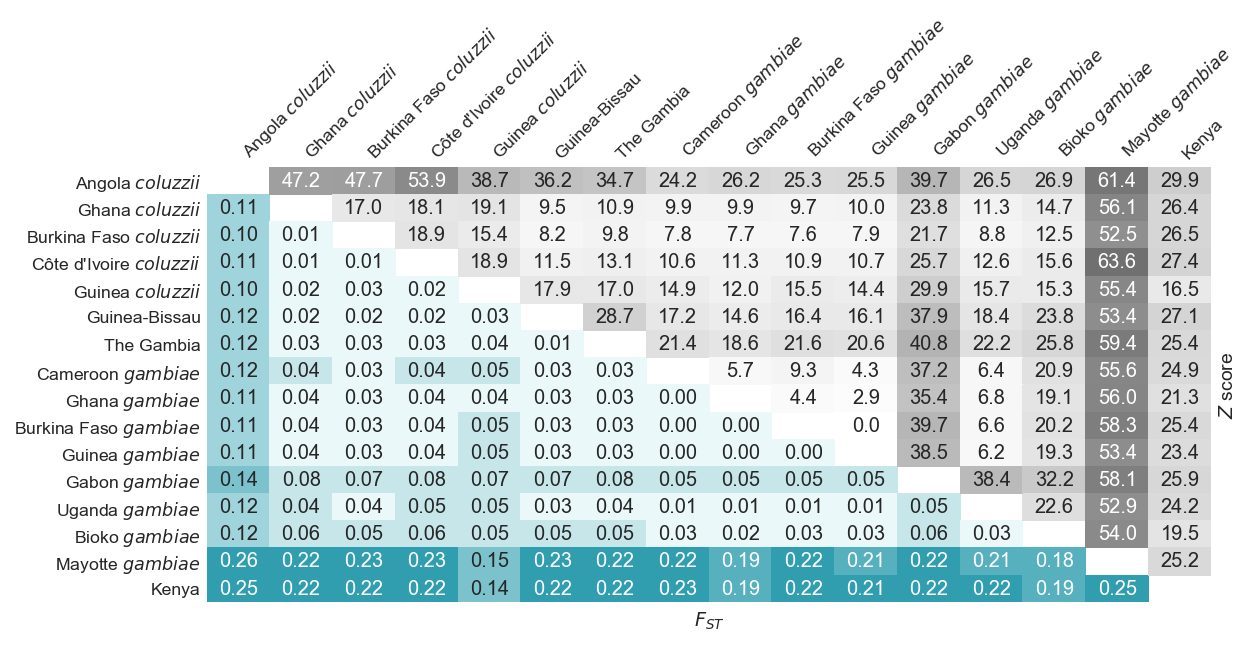

In [113]:
def fig_pairwise_fst(pops, figsize=(7, 3), fn=None):
    fig, ax = plt.subplots(figsize=figsize)
    plot_pairwise_fst_z(pops=pops, regions=(region_3R_free, region_3L_free), ax=ax)
    #ax.text(-0.15, 1.2, '\\textbf{b}', ha='left', va='top', transform=ax.transAxes, fontsize=10)
    return fig
## fn_template = '../artwork/pairwise_fst.{size}.{dpi}.jpeg'
fig = fig_pairwise_fst(pops=populations, figsize=(9, 4))
fig.savefig('../artwork/pairwise_fst.jpeg', dpi=300, bbox_inches='tight', jpeg_quality=100)
fig.savefig('../artwork/pairwise_fst.svg', dpi=300, bbox_inches='tight')

# dbltn shrng

In [100]:
callset_pass = phase2_ar1.callset_pass_biallelic
poppop_labels = phase2_ar1.pop_labels
population_dbl = list(poppop_labels.keys())
population_dbl.remove('colony')
#remove smol popz
population_dbl.remove('GNcol')
population_dbl.remove('GQgam')
population_dbl.remove('GHgam')
#fix colours
pop_col = [pop_colours[p] for p in population_dbl]
#fix labels
pop_label_dbl = [poppop_labels[p] for p in population_dbl]
popic = {}
count = 0
for p in population_dbl:
    popic[p] = count
    count += 1

In [88]:
def load_tbl_samples_sub(chrom, subsets, seed):
    
    random.seed(seed)
    
    with section('compute subset sizes'):
        subset_sizes = [len(df_samples[df_samples.population == q]) for q in population_dbl]
        n = min(subset_sizes)

    subsets_sidx = dict()
    for p in population_dbl:
        subsets_sidx[p] = sorted(random.sample(list(df_samples[df_samples.population == p].index), n))

    sidx = list(itertools.chain(*subsets_sidx.values()))
    
    return sidx 

In [89]:
sidx = load_tbl_samples_sub('3R', population_dbl, 42)

[compute subset sizes] begin
[compute subset sizes] done in a moment


In [90]:
def load_dbl_gn(chrom, sidx):
        
    with section('load and subset genotypes'):
        genotype = allel.GenotypeDaskArray(callset_pass[chrom]['calldata/genotype'])
        genotype_sub = genotype.take(sidx, axis=1)

    with section('count genotypes'):
        n_hom_alt = genotype_sub.count_hom_alt(axis=1).compute()
        
    with section('count alleles'):
        ac_sub = genotype_sub.count_alleles(max_allele=3).compute()

    with section('locate doubletons'):
        # use only ALT doubletons, ignore REF doubletons as very few
        loc_dbl = (ac_sub.max_allele() == 1) & (ac_sub[:, 1] == 2) & (n_hom_alt == 0)
    with section('compress genotypes to doubletons'):
        genotype_dbl = genotype_sub.compress(loc_dbl, axis=0)
        gn_dbl = genotype_dbl.to_n_alt().compute()

    return gn_dbl

In [91]:
df_samples_sub = df_samples.take(sidx)[['ox_code', 'population']]
df_samples_sub['subset_index'] = [popic[p] for p in list(df_samples_sub.population)]
df_samples_sub.reset_index(inplace=True)

In [92]:
def _dbl_count(x, y):
    return np.count_nonzero((x == 1) & (y == 1))

def count_pairwise_doubletons(chrom, subsets, seed):
    
    with section('subset samples'):
        sidx = load_tbl_samples_sub(chrom, subsets, seed)
    
    with section('load doubleton genotypes'):
        gn_dbl = load_dbl_gn(chrom, sidx)
    
    with section('count pairwise shared doubletons'):
        pairwise_dbl = allel.pairwise_distance(gn_dbl, _dbl_count, chunked=True)

    return pairwise_dbl#, gn_dbl, _dbl_count

In [81]:
pairwise_dbl_3R = count_pairwise_doubletons('3R', population_dbl, seed=42)

[subset samples] begin
  [compute subset sizes] begin
  [compute subset sizes] done in a moment
[subset samples] done in a moment
[load doubleton genotypes] begin
  [load and subset genotypes] begin
  [load and subset genotypes] done in a moment
  [count genotypes] begin
  [count genotypes] done in 49 seconds
  [count alleles] begin
  [count alleles] done in 55 seconds
  [locate doubletons] begin
  [locate doubletons] done in a moment
  [compress genotypes to doubletons] begin
  [compress genotypes to doubletons] done in 43 seconds
[load doubleton genotypes] done in 2 minutes
[count pairwise shared doubletons] begin
[count pairwise shared doubletons] done in a minute


In [82]:
pairwise_dbl_3L = count_pairwise_doubletons('3L', population_dbl, seed=42)

[subset samples] begin
  [compute subset sizes] begin
  [compute subset sizes] done in a moment
[subset samples] done in a moment
[load doubleton genotypes] begin
  [load and subset genotypes] begin
  [load and subset genotypes] done in a moment
  [count genotypes] begin
  [count genotypes] done in 30 seconds
  [count alleles] begin
  [count alleles] done in 37 seconds
  [locate doubletons] begin
  [locate doubletons] done in a moment
  [compress genotypes to doubletons] begin
  [compress genotypes to doubletons] done in 27 seconds
[load doubleton genotypes] done in a minute
[count pairwise shared doubletons] begin
[count pairwise shared doubletons] done in 49 seconds


In [116]:
def plot_pw_dbl_sub_nof2(pairwise_dbl, populations, pop_col, pop_labels, df_samples_sub, fig=None):
    assert len(populations) == len(pop_col)
    
    n = df_samples_sub.shape[0]
    yy = list()
    ee = list()
    for subset_id1 in population_dbl:
        pop1 = list(df_samples_sub[df_samples_sub.population == subset_id1].index)
        y = list()
        e = list()
        for subset_id2 in population_dbl:
            if subset_id1 != subset_id2:
                pop2 = list(df_samples_sub[df_samples_sub.population == subset_id2].index)
                pidx = allel.condensed_coords_between(pop1, pop2, n)
            else:
                pidx = allel.condensed_coords_within(pop1, n)
            d = pairwise_dbl.take(pidx)
            y.append(np.mean(d))
            e.append(scipy.stats.sem(d))
        yy.append(y)
        ee.append(e)
    yy = np.array(yy)
    ee = np.array(ee)

    # yy is number of doubletons shared
    if fig is None:
        fig = plt.figure(figsize=(1 + .3*len(population_dbl), 1 + .3*len(population_dbl)))
        
    gs = GridSpec(len(population_dbl), 2, width_ratios=(9, 1))
    
    for i1 in range(len(population_dbl)):    
        ax = fig.add_subplot(gs[i1, 0])
        sns.despine(ax=ax, left=True, bottom=True, top=True)
        p1 = pop_label_dbl[i1]
        y = yy[i1]
        e = ee[i1]
        ax.bar(np.arange(len(population_dbl)) + .05, y, width=.9, color=pop_col, lw=0)
        ax.set_xlim(0, len(population_dbl))
        ax.set_xticks([])
        ax.set_ylabel(p1, fontweight='bold', color="#2b2b2b", rotation=0, ha='right', va='center')
        ymax = np.sum(y)
        ax.set_ylim(0, ymax)
        ax.set_yticks([])
        if i1 == 0:
            for i in range(len(population_dbl)):
                ax.text((i+.4)/len(population_dbl), 1.1, pop_label_dbl[i], color=pop_col[i], transform=ax.transAxes, rotation=45,
                        ha='left', va='bottom', fontweight='bold')
    
#             # add f2 label
#             ax.text(x=(i+1.9)/len(populations), y=1.1, s='$f_{2}$ variants', 
#                     color="#525252", transform=ax.transAxes, rotation=45,
#                     ha='left', va='bottom', fontweight='bold')
            
#     # define upper limit of right hand bar plot
#     maxsum = yy.sum(axis=1).max() * 1.05
#     ceiling = np.ceil(maxsum/10) * 10
    
#     for i1 in range(len(populations)):    
        
#         ax2 = fig.add_subplot(gs[i1, 1])
#         y = yy[i1]            
#         #ax2 = fig.add_subplot(gs[:, 1])
#         ax2.barh([0.5], [np.sum(y)], color='#525252', align="center", height=0.8)
#         ax2.set_xlim((0, ceiling))
        
#         #if i1 == (len(subsets) -1):
#         if False:
#             sns.despine(ax=ax2, left=True, bottom=False, top=True)
#             ax2.set_xticks((0, ceiling))
#         else:
#             sns.despine(ax=ax2, left=True, bottom=True, top=True)
#             ax2.set_xticks([])
        
#         ax2.set_yticks([])
# #             ax.tick_params(length=0)
# #             ax.xaxis.tick_top()
# #             ax.set_xticklabels(subset_labels, rotation=45, ha='left')

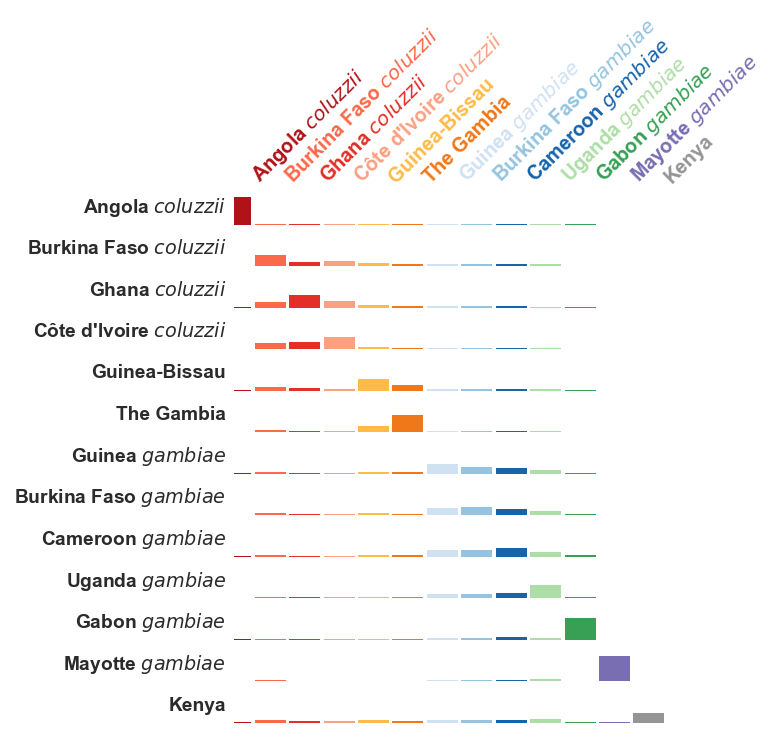

In [117]:
plot_pw_dbl_sub_nof2(pairwise_dbl_3L + pairwise_dbl_3R, 
                population_dbl, pop_col, pop_label_dbl, df_samples_sub)

In [121]:
def fig_pop_dbl_nof2(figsize=(5, 3), fn=None, dpi=600):
    fig = plt.figure(figsize=figsize)
    plot_pw_dbl_sub_nof2(pairwise_dbl_3L + pairwise_dbl_3R, 
                    population_dbl, pop_col, pop_label_dbl, df_samples_sub, fig=fig)
    ax = fig.axes[0]
    #ax.text(-0.3, 3, '\\textbf{c}', ha='left', va='top', transform=ax.transAxes, fontsize=10)

    if fn:
        fig.savefig(fn, jpeg_quality=100, dpi=dpi, bbox_inches='tight')

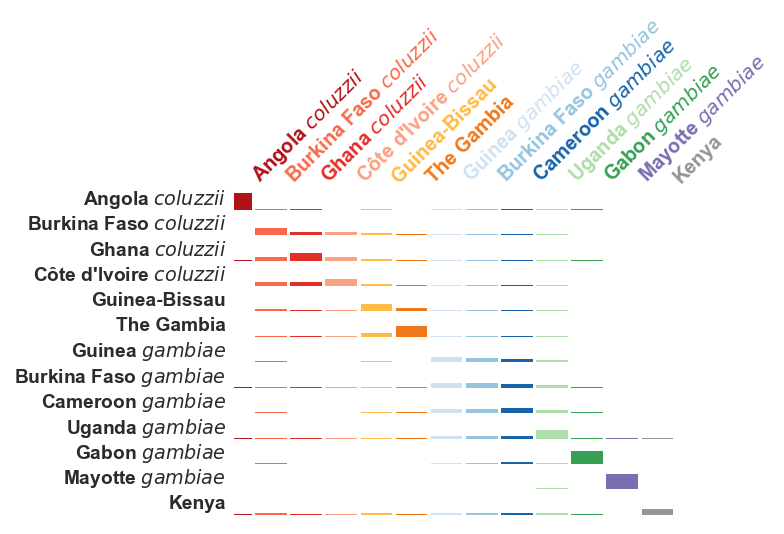

In [122]:
fig_pop_dbl_nof2(figsize=(5, 3), 
            fn='../artwork/doubletons_nof2.jpeg', 
            dpi=900)

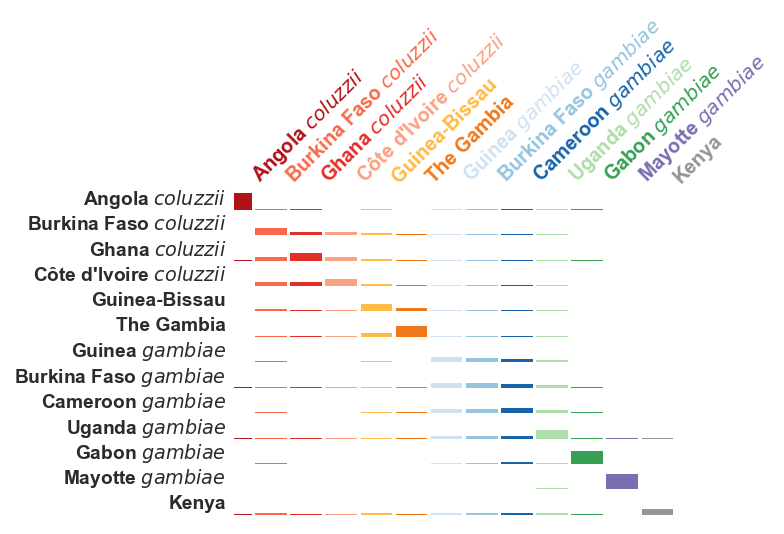

In [125]:
fig_pop_dbl_nof2(figsize=(5, 3), 
            fn='../artwork/doubletons_nof2.svg', 
            dpi=900)

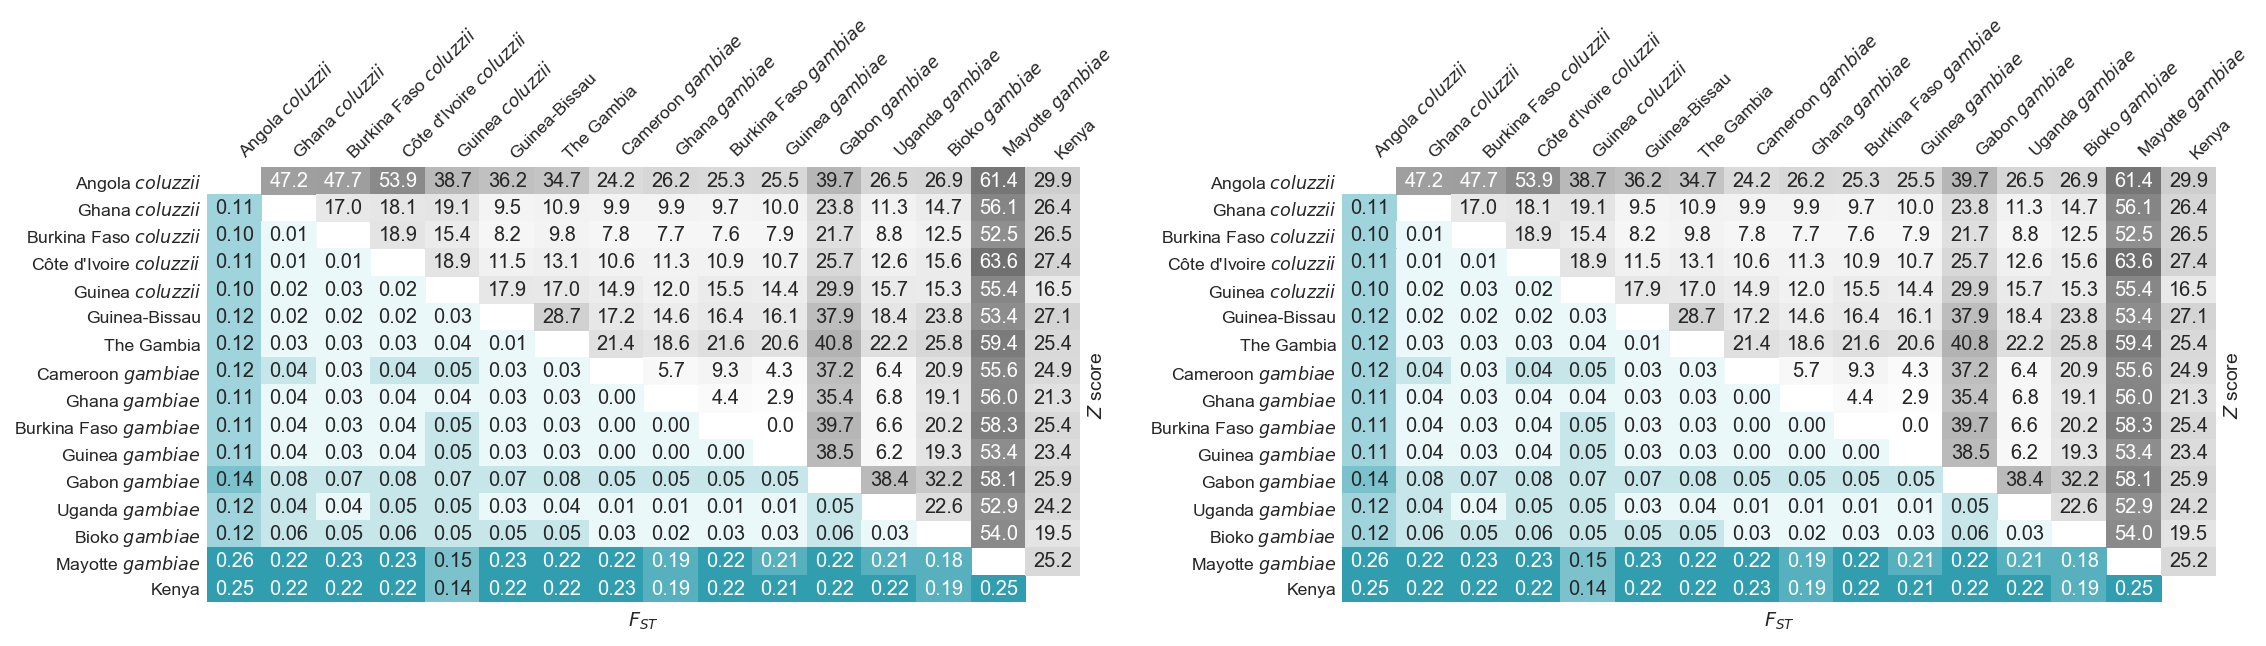

In [106]:
# create the figure
fig = plt.figure(figsize=(18, 4))

# define subplot layout
gs_nrows = 1
gs_ncols = 2
gs = mpl.gridspec.GridSpec(gs_nrows, gs_ncols, hspace=0.04, wspace=0.3)

ax1 = fig.add_subplot(gs[0])
plot_pairwise_fst_z(pops=populations, regions=(region_3R_free, region_3L_free), ax=ax1)
ax2 = fig.add_subplot(gs[1])
plot_pairwise_fst_z(pops=populations, regions=(region_3R_free, region_3L_free), ax=ax2);